### **Install and import packages**

In [ ]:
!pip install -U tensorly ecg-plot iteration_utilities 

import os
import tarfile
import timeit
import random
import math
import re
import itertools

from google.colab import drive
from operator import itemgetter
from scipy.signal import cheby2, resample, sosfilt
from scipy.io import loadmat, savemat
from tensorly import tensor as tensor_tly
from tensorly import norm, dot
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.activations import relu
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2, l1_l2

import numpy as np
import pandas as pd
import ecg_plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### **Get header and recordings filenames**

In [ ]:
import logging


class Diagnostic(object):
  diagnostics = []


  @classmethod
  def append_diagnostic(cls, diagnostic):
    cls.diagnostics.append(diagnostic)


  @classmethod
  def get_diagnostics(cls):
    return cls.diagnostics


  def __init__(self, diag_name, abbrev, code):
    self.name = diag_name
    self.abbrev = abbrev
    self.code = code


class Database(object):
  def __init__(self, folder, path_drive, leads):
    self.folder = folder
    self.path_drive = path_drive
    self.leads = leads
    self.freq = 0
    self.headers_path = []
    self.recordings_path = []
    

  def extract_from_drive(self):
    if not os.path.exists(self.folder):
      with tarfile.open(self.path_drive) as zip_file:
        zip_file.extractall()
    

  def load_hea_file(self, i):
    with open(self.headers_path[i], 'r') as f:
      hea_file = f.read()
    return hea_file


  def get_frequency(self):
    header = self.load_hea_file(0)
    for i, l in enumerate(header.split('\n')):
        if i==0:
            try:
                self.freq = float(l.split(' ')[2])
            except:
                pass
        else:
            break
    print(f'Frequency: {self.freq}')

    

  def __str__(self):
    return f'Database(folder={self.folder}, path_drive={self.path_drive}, freq={self.freq},  leads={self.leads}, headers_paths={len(self.headers_paths)}, recordings_paths={len(self.recordings_paths)})'


  def load_paths(self):
    for f in sorted(os.listdir(self.folder)):
      root, extension = os.path.splitext(f)
      if not root.startswith('.') and extension=='.hea':
        header_db_file = os.path.join(self.folder, root + '.hea')
        recording_db_file = os.path.join(self.folder, root + '.mat')
        if os.path.isfile(header_db_file) and os.path.isfile(recording_db_file):
          self.headers_path.append(header_db_file)
          self.recordings_path.append(recording_db_file)
    print(f'Found {len(self.headers_path)} recordings in {self.folder}.')



class DiagnosticDatabase(object):
  databases = []

  @classmethod
  def append_database(cls, diag_db):
    cls.databases.append(diag_db)
    

  def __init__(self, diag_origin, db_origin):
    self.diagnostic = diag_origin
    self.db = db_origin
    self.headers_diag_path = []
    self.recordings_diag = []
    #self.logger = logger


  def get_labels(self, header):
    labels = list()
    for l in header.split('\n'):
      if l.startswith('#Dx'):
        try:
          entries = l.split(': ')[1].split(',')
          for entry in entries:
            labels.append(entry.strip())
        except:
          pass
    return labels


  def get_leads(self,header):
    leads = list()
    for i, l in enumerate(header.split('\n')):
      entries = l.split(' ')
      if i==0:
        num_leads = int(entries[1])
      elif i<=num_leads:
        leads.append(entries[-1])
      else:
        break
    return tuple(leads)


  def choose_leads(self, recording, header, leads):
    num_leads = len(leads)
    num_samples = np.shape(recording)[1]
    chosen_recording = np.zeros((num_leads, num_samples), recording.dtype)
    available_leads = self.get_leads(header)
    for i, lead in enumerate(leads):
      if lead in available_leads:
        j = available_leads.index(lead)
        chosen_recording[i, :] = recording[j, :]
    return chosen_recording



  def prepare_data(self, freq, interval):
    for i, header_path in enumerate(self.db.headers_path):
      header = self.db.load_hea_file(i)
      labels = self.get_labels(header)
      if self.diagnostic.code in labels:
        # Get record
        rec_file = header_path.replace('hea', 'mat')
        recording = loadmat(rec_file)['val']
        recording = self.choose_leads(recording, header, self.db.leads)

        # Resample record
        time_rec = len(recording[0])/self.db.freq
        n_samples = int(time_rec*freq)
        recording = resample(recording, n_samples, axis=1)

        # Cut record
        size_rec = recording.shape[1]
        samples_rec = math.floor(size_rec/interval)
        for i in range(0, samples_rec):
          inf = i*interval
          sup = ((i+1)*interval)
          recording_interval = np.array(list(map(lambda lead: lead[inf:sup], recording)))
          self.recordings_diag.append(recording_interval)

        self.headers_diag_path.append(header_path)

    print(f' - Found {len(self.headers_diag_path)} recordings for {self.diagnostic.abbrev}.')
    print(f' - Unattached {len(self.recordings_diag)} intervals.')


  def plot_ecg(self, index):
    ecg_plot.plot(self.rsp_cut_recordings_diag[index]/1000, sample_rate=self.db.freq/2, title='')
    ecg_plot.show()

# Define diagnosis
af_diag = Diagnostic('Atrial Fibrilation', 'AF', '164889003')
sr_diag = Diagnostic('Sinus Rhythm', 'SR', '426783006')
Diagnostic.append_diagnostic(af_diag)
Diagnostic.append_diagnostic(sr_diag)

In [ ]:
#from io import StringIO
#log_stream = StringIO()   
#logging.basicConfig(stream=log_stream, format='%(asctime)s - %(message)s', level=logging.INFO)

# Define Database
drive.mount('/content/gdrive')
path_folder = '/content/gdrive/MyDrive/Pesquisa Mestrado/Parte II (Novembro-)/Databases/PhysioNet-CinC21/'
available_databases = os.listdir(path_folder)
available_databases.remove('WFDB_PTB.tar.gz')
available_databases.remove('WFDB_StPetersburg.tar.gz')
available_databases = list(map(lambda db: path_folder + db, available_databases))

# Other params
leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')

for path_drive in available_databases[1:2]:
  folder = re.search('PhysioNet-CinC21/(.*).tar.gz', path_drive).group(1)
  db = Database(folder, path_drive, leads)
  db.extract_from_drive()
  db.load_paths()
  db.get_frequency()
  for diag in Diagnostic.get_diagnostics():
    diag_db = DiagnosticDatabase(diag, db)
    diag_db.prepare_data(freq=250, interval=250) 
    #DiagnosticDatabase.append_database(diag_db)
  print()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 6877 recordings in WFDB_CPSC2018.
Frequency: 500.0
 - Found 1221 recordings for AF.
 - Unattached 18306 intervals.
 - Found 918 recordings for SR.
 - Unattached 14116 intervals.



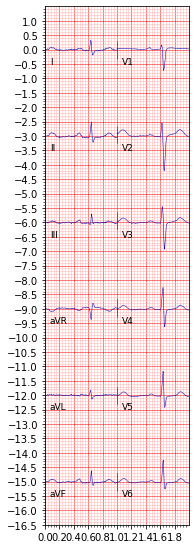

In [ ]:
# Filtering
from scipy.signal import lfilter

rec = diag_db.recordings_diag[0]
''' for i in range(0, samples_rec):
  sos = cheby2(2, 20, [0.35, 70], 'bandpass', analog=True)
  recording = sosfilt(sos, recording) '''

filt_recording = np.zeros((12, 250), rec.dtype)
for i in range(0, 11):
  rec_lead = rec[i, :]
  a, b  = cheby2(5, 34, [0.35, 0.70], 'bandpass', analog=False)
  filt_recording[i, :] = lfilter(a, b, rec_lead)

ecg_plot.plot(rec/1000, sample_rate=250, title='')
ecg_plot.show()

### **Configs to extract data**

- RESAMPLE SIGNAL (NYQUIST) ALL DATABASES 

  - scipy.signal.resample 
  - https://stackoverflow.com/questions/38599612/calculate-nyquist-frequency-of-signal-from-a-data-set

- CUT HIGH AND LOW FREQUENCIES
  - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cheby2.html
- TENSOR APPROACH
 - HANKELIZATION 
   - scipy.linalg.hankel

- Multilabel
  - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html

# **Tensor Approach**

In [ ]:
from scipy.linalg import hankel

sampling = 250

def get_indexes_hankel(n):
  if (n % 2):
    i = (n+1)/2
    j = i
  else:
    i = n/2
    j = i + 1
  return int(i), int(j)


i, j = get_indexes_hankel(sampling)
T = np.zeros((i, j, 12))
for lead in range(0, 11):
  T[:,:, lead] = hankel(diag_db.recordings_diag[0][lead, :])[0:i, 0:j]

In [ ]:
recording = diag_db.recordings_diag[0]
savemat('/hankel_record.mat', { 'hankel_record': T })

### **Functions**

In [ ]:
def pci(T, R, rank, max_iter=1000, min_decrease=1e-5):
  shape = T.shape
  dim = range(len(rank))
  tensors = [tensor_tly(np.zeros(shape)) for r in range(R)]
  last = 1
  for i in range(max_iter):
    btd = []  
    print(f"[Iter {i+1}]")
    for r in range(R):
      Tres = T - (sum(tensors) - tensors[r])
      print(f"     HOOI {r+1}", end="")
      Td = tucker(tensor=Tres, rank=rank, n_iter_max=max_iter, init='svd', svd='numpy_svd', tol=min_decrease)
      btd.append(Td)
      Tapprox = tucker_to_tensor(Td)
      print(f"     Norm {norm(Tapprox)}")
      tensors[r] = Tapprox
    Tres = T - sum(tensors)
    error = norm(Tres)/norm(T)
    decrease = last - error
    print("    -----------------------------")
    print(f"    Error {error}")
    print(f"    Decrease {decrease}\n")
    if decrease <= min_decrease:
      break
    last = error
  return btd, tensors


def BTD(T, R, m_rank):
  start = timeit.default_timer()
  terms, _ = pci(T, R, m_rank)
  stop = timeit.default_timer()
  execution_time = str(stop - start)
  print(f"Program Executed in {execution_time}")
  return terms


def dehankelization(h_matrix):
  deh_matrix = []
  h, w = h_matrix.shape
  for i in range(0, h):
    if i != h-1:
      deh_matrix.append(h_matrix[i, i])
      deh_matrix.append(h_matrix[i, i+1])
  if w != h:
    deh_matrix.append(h_matrix[-1, -2])
  deh_matrix.append(h_matrix[-1, -1])
  return np.array(deh_matrix)


def print_terms(terms):
  t = 0
  print(f'TD {t}')
  print(terms[t][0].shape)
  print(terms[t][1][0].shape)
  print(terms[t][1][1].shape)
  print(terms[t][1][2].shape)
  print()
    

### **Decomposing BTD**

In [ ]:
T = tensor_tly(T)
R = 12
m_rank = [95, 95, 1]
terms = BTD(T, R, m_rank)

[Iter 1]
     HOOI 1     Norm 41432.506232952495
     HOOI 2     Norm 28864.175086807274
     HOOI 3     Norm 7531.986789573791
     HOOI 4     Norm 3605.941610106473
     HOOI 5     Norm 2249.0603223941002
     HOOI 6     Norm 762.2090438244911
     HOOI 7     Norm 423.78016097818676
     HOOI 8     Norm 247.08099228350153
     HOOI 9     Norm 226.8990358455539
     HOOI 10     Norm 174.27806943847278
     HOOI 11     Norm 120.8051574995593
     HOOI 12     Norm 83.40786856309734
    -----------------------------
    Error 0.0017140529079851265
    Decrease 0.9982859470920149

[Iter 2]
     HOOI 1     Norm 41432.57624539606
     HOOI 2     Norm 28864.18725742922
     HOOI 3     Norm 7531.73290486321
     HOOI 4     Norm 3606.2058352914123
     HOOI 5     Norm 2248.9826386680147
     HOOI 6     Norm 762.2655926114525
     HOOI 7     Norm 423.7909034699898
     HOOI 8     Norm 247.28322970168716
     HOOI 9     Norm 226.9906072153499
     HOOI 10     Norm 174.41834176966537
     HOOI 11

### **View results**

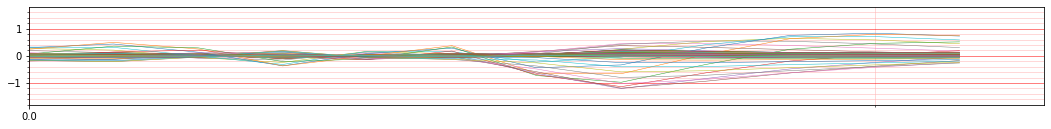

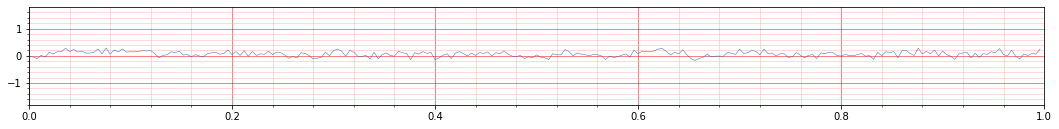

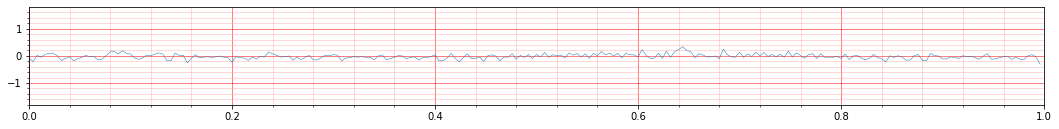

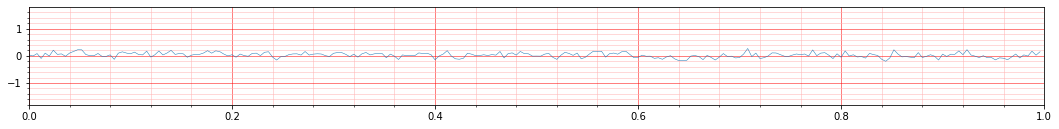

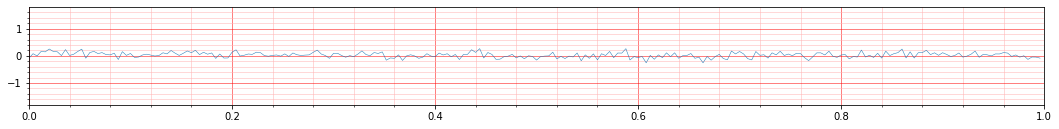

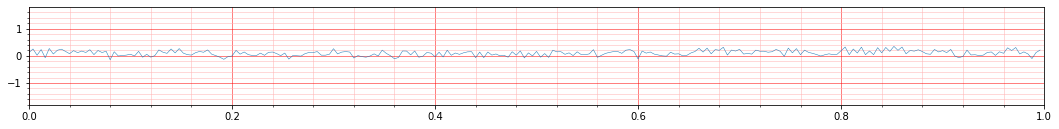

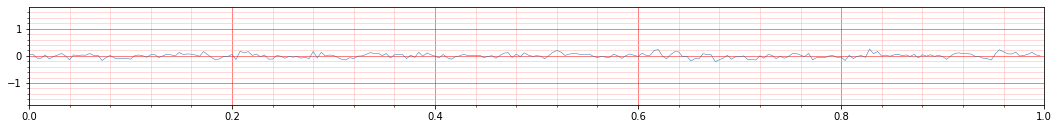

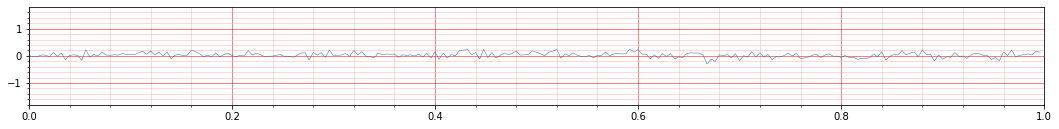

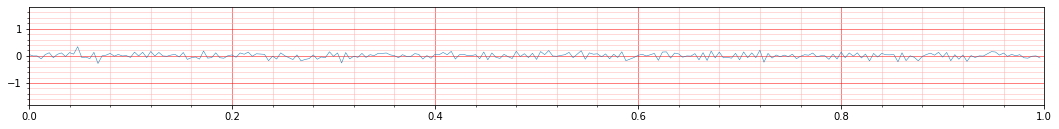

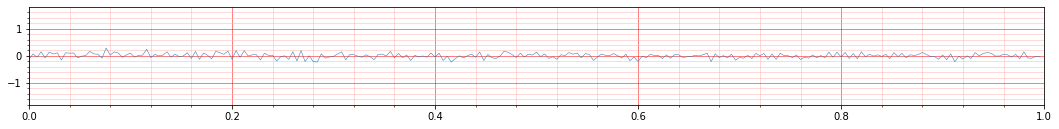

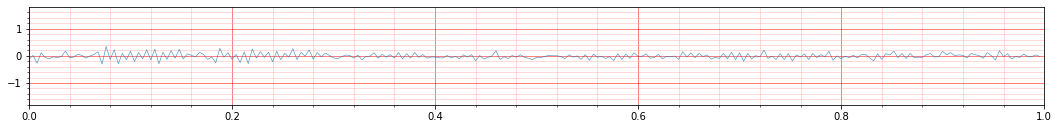

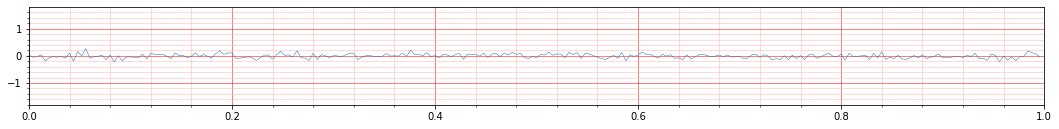

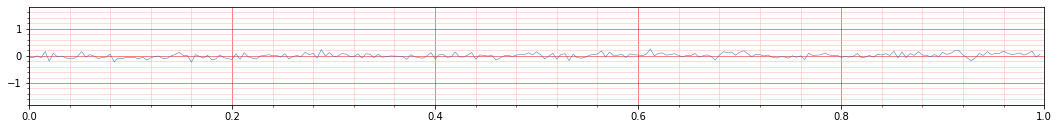

In [ ]:
# source 1
ecg_plot.plot_1(diag_db.recordings_diag[0]/1000, sample_rate=250, title='')
ecg_plot.show()

for r in range(0, R):
  h_d = dot(terms[r][1][0], terms[r][1][1].T)
  deh_d = dehankelization(h_d)
  ecg_plot.plot_1(deh_d, sample_rate=250, title='')
  ecg_plot.show()

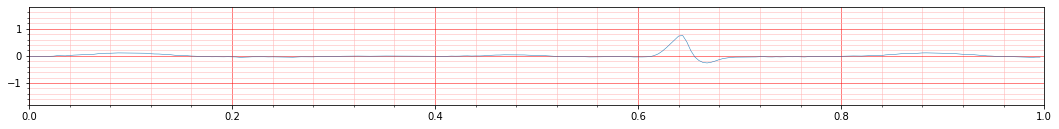

In [ ]:
# source 1
ecg_plot.plot_1(diag_db.recordings_diag[0][11]/1000, sample_rate=250, title='')
ecg_plot.show()

# **Convolutional Neural Network**

### **Functions**

In [ ]:
diag_db.recordings_diag[0][0]

array([-1.15601735e+01,  5.62337496e+00,  8.13465958e+00,  9.31350538e+00,
       -7.53766088e-01, -1.00434437e+01, -5.31681586e+00, -4.64493974e+00,
        3.10932563e+00,  2.89484697e+01,  2.96494628e+01,  1.00706495e+01,
        1.04183816e+01,  5.23862152e+00,  9.46462941e+00,  3.43264036e+01,
        5.01642034e+01,  6.40403250e+01,  6.31629439e+01,  6.88337380e+01,
        7.54084220e+01,  7.63736275e+01,  7.72055128e+01,  7.88688547e+01,
        6.03730889e+01,  5.69437727e+01,  5.38450894e+01,  5.12658358e+01,
        6.95727828e+01,  6.61781696e+01,  6.56166155e+01,  4.94755440e+01,
        4.01105689e+01,  4.28384562e+01,  3.36952061e+01,  2.59230500e+01,
        1.10925349e+01,  4.70375632e+00,  2.18943899e+01,  2.20674307e+01,
        8.71765581e+00, -1.92930793e+00, -1.64547690e+01, -1.97637687e+01,
       -6.64927315e+00,  2.40534657e+00, -6.31284651e+00, -1.02470328e+01,
       -1.69465404e+01, -3.75740255e+01, -2.08524087e+01, -8.83910678e+00,
       -1.20868194e+01, -

In [ ]:
def cnn_1(input_shape):
  model = Sequential()
  model.add(Conv2D(64, kernel_size=(1, 4), strides=3, input_shape=input_shape))
  model.add(Activation(relu))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
  model.add(Conv2D(32, kernel_size=(1, 8), strides=3))
  model.add(Activation(relu))
  model.add(MaxPooling2D(pool_size=(1, 10), strides=3))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(50, activation='linear'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.summary()
  return model


# https://github.com/mbarzegary/ecg-classification-keras-cnn/blob/master/train_keras.py
def cnn_2(input_shape):
  model = Sequential()
  model.add(Conv2D(64, (4, 4), input_shape=input_shape, padding='same', kernel_regularizer=l1_l2(0.0001, 0.0001), activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (4, 4), kernel_regularizer=l2(0.0001), padding='same', activation='relu'))
  model.add(MaxPooling2D((4, 4)))
  model.add(Dropout(0.20))
  model.add(Conv2D(256, (4, 4), kernel_regularizer=l2(0.0001), padding='same', activation='relu'))
  model.add(Conv2D(256, (4, 4), kernel_regularizer=l2(0.0001), padding='same', activation='relu'))
  model.add(MaxPooling2D())
  model.add(Dropout(0.20))
  model.add(Flatten())
  model.add(Dense(256, kernel_regularizer=l2(0.0001), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  model.summary()
  return model


def build_model(model, epochs, batch_size, train_x, test_x, train_y, test_y):
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  callbacks_list = [
      keras.callbacks.ModelCheckpoint(
          filepath='model.h5',
          monitor='val_loss', save_best_only=True, verbose=1),
      keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
  ]

  return model.fit(X_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   callbacks = callbacks_list,
                   verbose=1,
                   validation_data=(X_test, y_test))


def plot_results(model):  
  fig, ax = plt.subplots(1,2, figsize=(16,8))
  ax[0].plot(model.history['loss'], color='b', label="Training loss")
  ax[0].plot(model.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  legend = ax[0].legend(loc='best', shadow=True)

  ax[1].plot(model.history['accuracy'], color='b', label="Training accuracy")
  ax[1].plot(model.history['val_accuracy'], color='r',label="Validation accuracy")
  legend = ax[1].legend(loc='best', shadow=True)

### **Preparing Data**

In [ ]:
X = np.vstack((recordings_AF, recordings_SR))
y = np.hstack((np.ones(len(recordings_AF)).T, np.zeros(len(recordings_SR)).T))
y = keras.utils.to_categorical(y, 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = X_train.reshape([*X_train.shape[0:3], 1])
X_test = X_test.reshape([*X_test.shape[0:3], 1])

### **Classifier**

In [ ]:
net = cnn_2(X_train.shape[1:])
# net = cnn_2()
batch_size = 124
epochs = 10
model = build_model(net, epochs, batch_size, X_train, y_train, X_test, y_test)
plot_results(model)

### **Load Model**

Model1 - 09-01
 - WFDB_CPSC2018
 - Train (21722, 12, 500)
 - Test (10700, 12, 500)
 - CNN_2
 - Epochs 10, Batch Size 124
 - ~ 10h

In [ ]:
loaded_model = load_model('/content/gdrive/MyDrive/Pesquisa Mestrado/Parte II (Novembro-)/Databases/Models/Model1.h5')
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print ("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))